In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score , average_precision_score, f1_score, classification_report, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from scipy.stats import mstats
from sklearn.model_selection import RandomizedSearchCV

import warnings # Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Data

datos_raw = pd.read_csv('data_train.csv', sep = ',')
datos_raw.head(5)

,Unnamed: 0,age,sex,dzgroup,dzclass,num.co,scoma,avtisst,race,sps,...,dnr,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
0,0,62.84998,male,Lung Cancer,Cancer,0,0.0,7.000000,other,33.898438,...,no dnr,5.0,97.0,69.0,22.0,36.00000,1.199951,141.0,7.0,0
1,1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,44.0,29.000000,white,52.695312,...,NaN,NaN,43.0,112.0,34.0,34.59375,5.500000,132.0,1.0,1
2,2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,0.0,13.000000,white,20.500000,...,no dnr,17.0,70.0,88.0,28.0,37.39844,2.000000,134.0,0.0,0
3,3,42.38498,female,Lung Cancer,Cancer,2,0.0,7.000000,white,20.097656,...,no dnr,3.0,75.0,88.0,32.0,35.00000,0.799927,139.0,0.0,0
4,4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,26.0,18.666656,white,23.500000,...,no dnr,16.0,59.0,112.0,20.0,37.89844,0.799927,143.0,2.0,0


In [3]:
# Crear una copia de los datos y remover la variable Unnamed: 0 (indice)

datos = datos_raw.copy()
datos.drop(datos.columns[0], axis=1, inplace=True)

# **Adecuación y Preprocesamiento de los Datos**

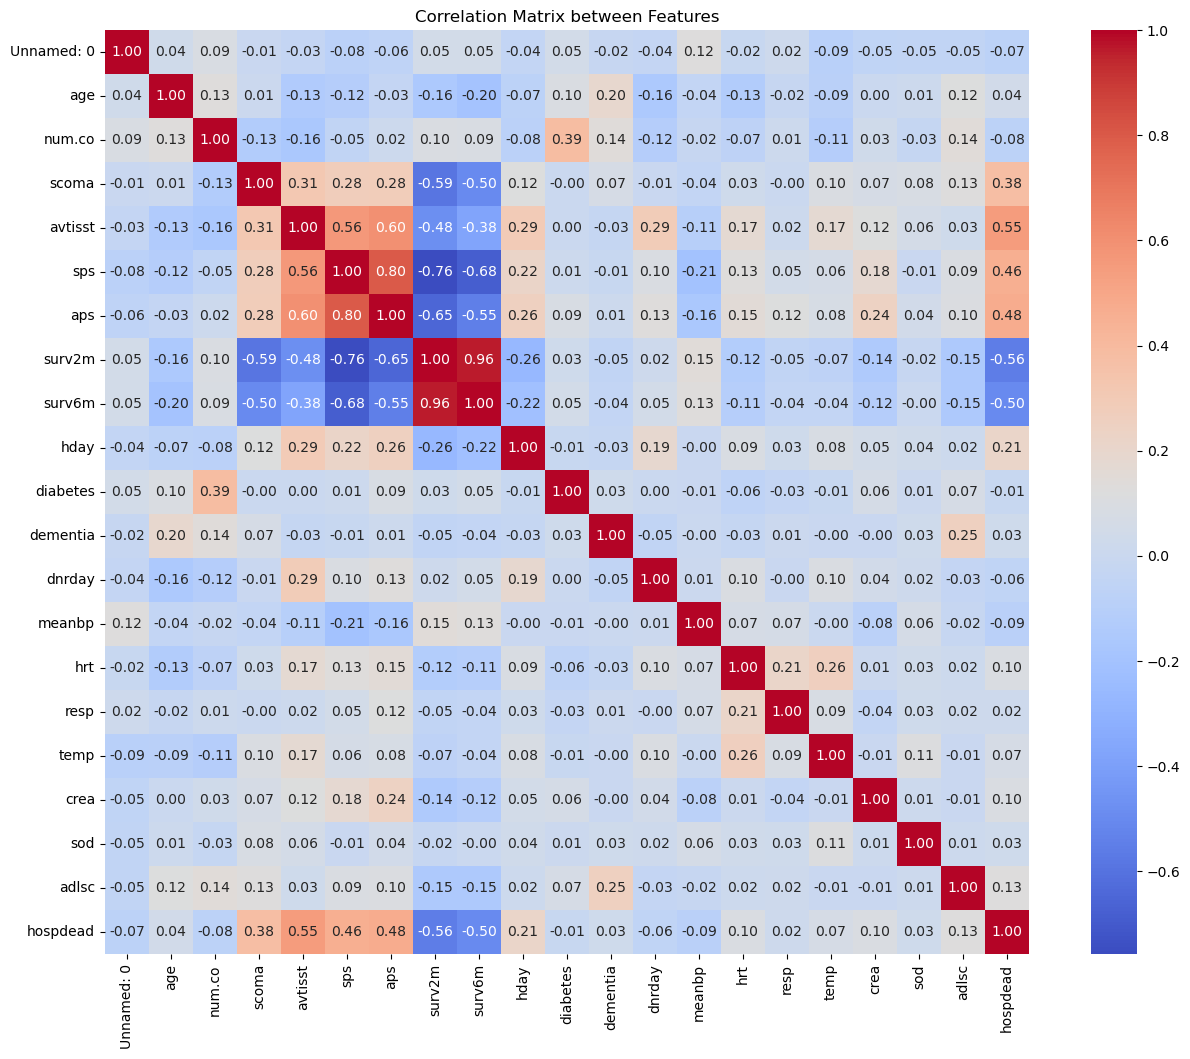

In [5]:
# Create a copy of the data and remove the variable Unnamed: 0 (index)

corr_matrix = datos_raw.select_dtypes(include = [float, int]).corr()
plt.figure(figsize = (16, 12))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = 'coolwarm', square = True)#
plt.title('Correlation Matrix between Features')
plt.show()

From the correlation matrix we can notice that the features 'surv2m' and 'surv6m' have an almost identical linear relationship (0.96/1.0) so including both does not provide more information than having only one of the two. For this reason, it was decided to remove the 'surv6m' feature in passing by reducing the dimensionality by one degree. It was also considered to eliminate sps since it has a correlation of 0.8 with aps but since it is not higher than 90 to 95 % (the correlation) and there is no more information about the characteristics, it was decided to leave it.

In [7]:
# Eliminate surv6m

datos.drop(columns = ['surv6m'], inplace = True)

We have a positive-to-negative class ratio of 1:2.86
Total negatives: 6745
Total positives: 2360


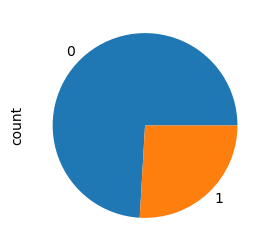

In [8]:
# Revision of class balance

plt.figure(figsize = (3, 3)) 
datos['hospdead'].value_counts().plot(kind='pie')
c0 = datos['hospdead'].value_counts()[0]
c1 = datos['hospdead'].value_counts()[1]
print(f'We have a positive-to-negative class ratio of 1:{round(c0/c1,2)}')
print(f'Total negatives: {c0}')
print(f'Total positives: {c1}')

In [9]:
# Checking for Duplicates and Incomplete Data

print(f'Duplicates in negative class: {datos_raw[datos["hospdead"] == 0].duplicated().sum()}')
print(f'Duplicates in positive class: {datos_raw[datos["hospdead"] == 1].duplicated().sum()}')
print(f'Null values in negative class: {datos_raw[datos["hospdead"] == 0].isna().sum().sum()}')
print(f'Null values in positive class: {datos_raw[datos["hospdead"] == 1].isna().sum().sum()}')

Duplicates in negative class: 0
Duplicates in positive class: 0
Null values in negative class: 191
Null values in positive class: 70


Since there is an adequate amount of data in both classes (considering the amount of null data), it is decided not to impute and, instead, to remove the null data from the data set. Note: This action of imputation would be performed after separating the data into training and test sets to avoid data leakage.

In [11]:
# Eliminating the NaN

datos.dropna(inplace = True)

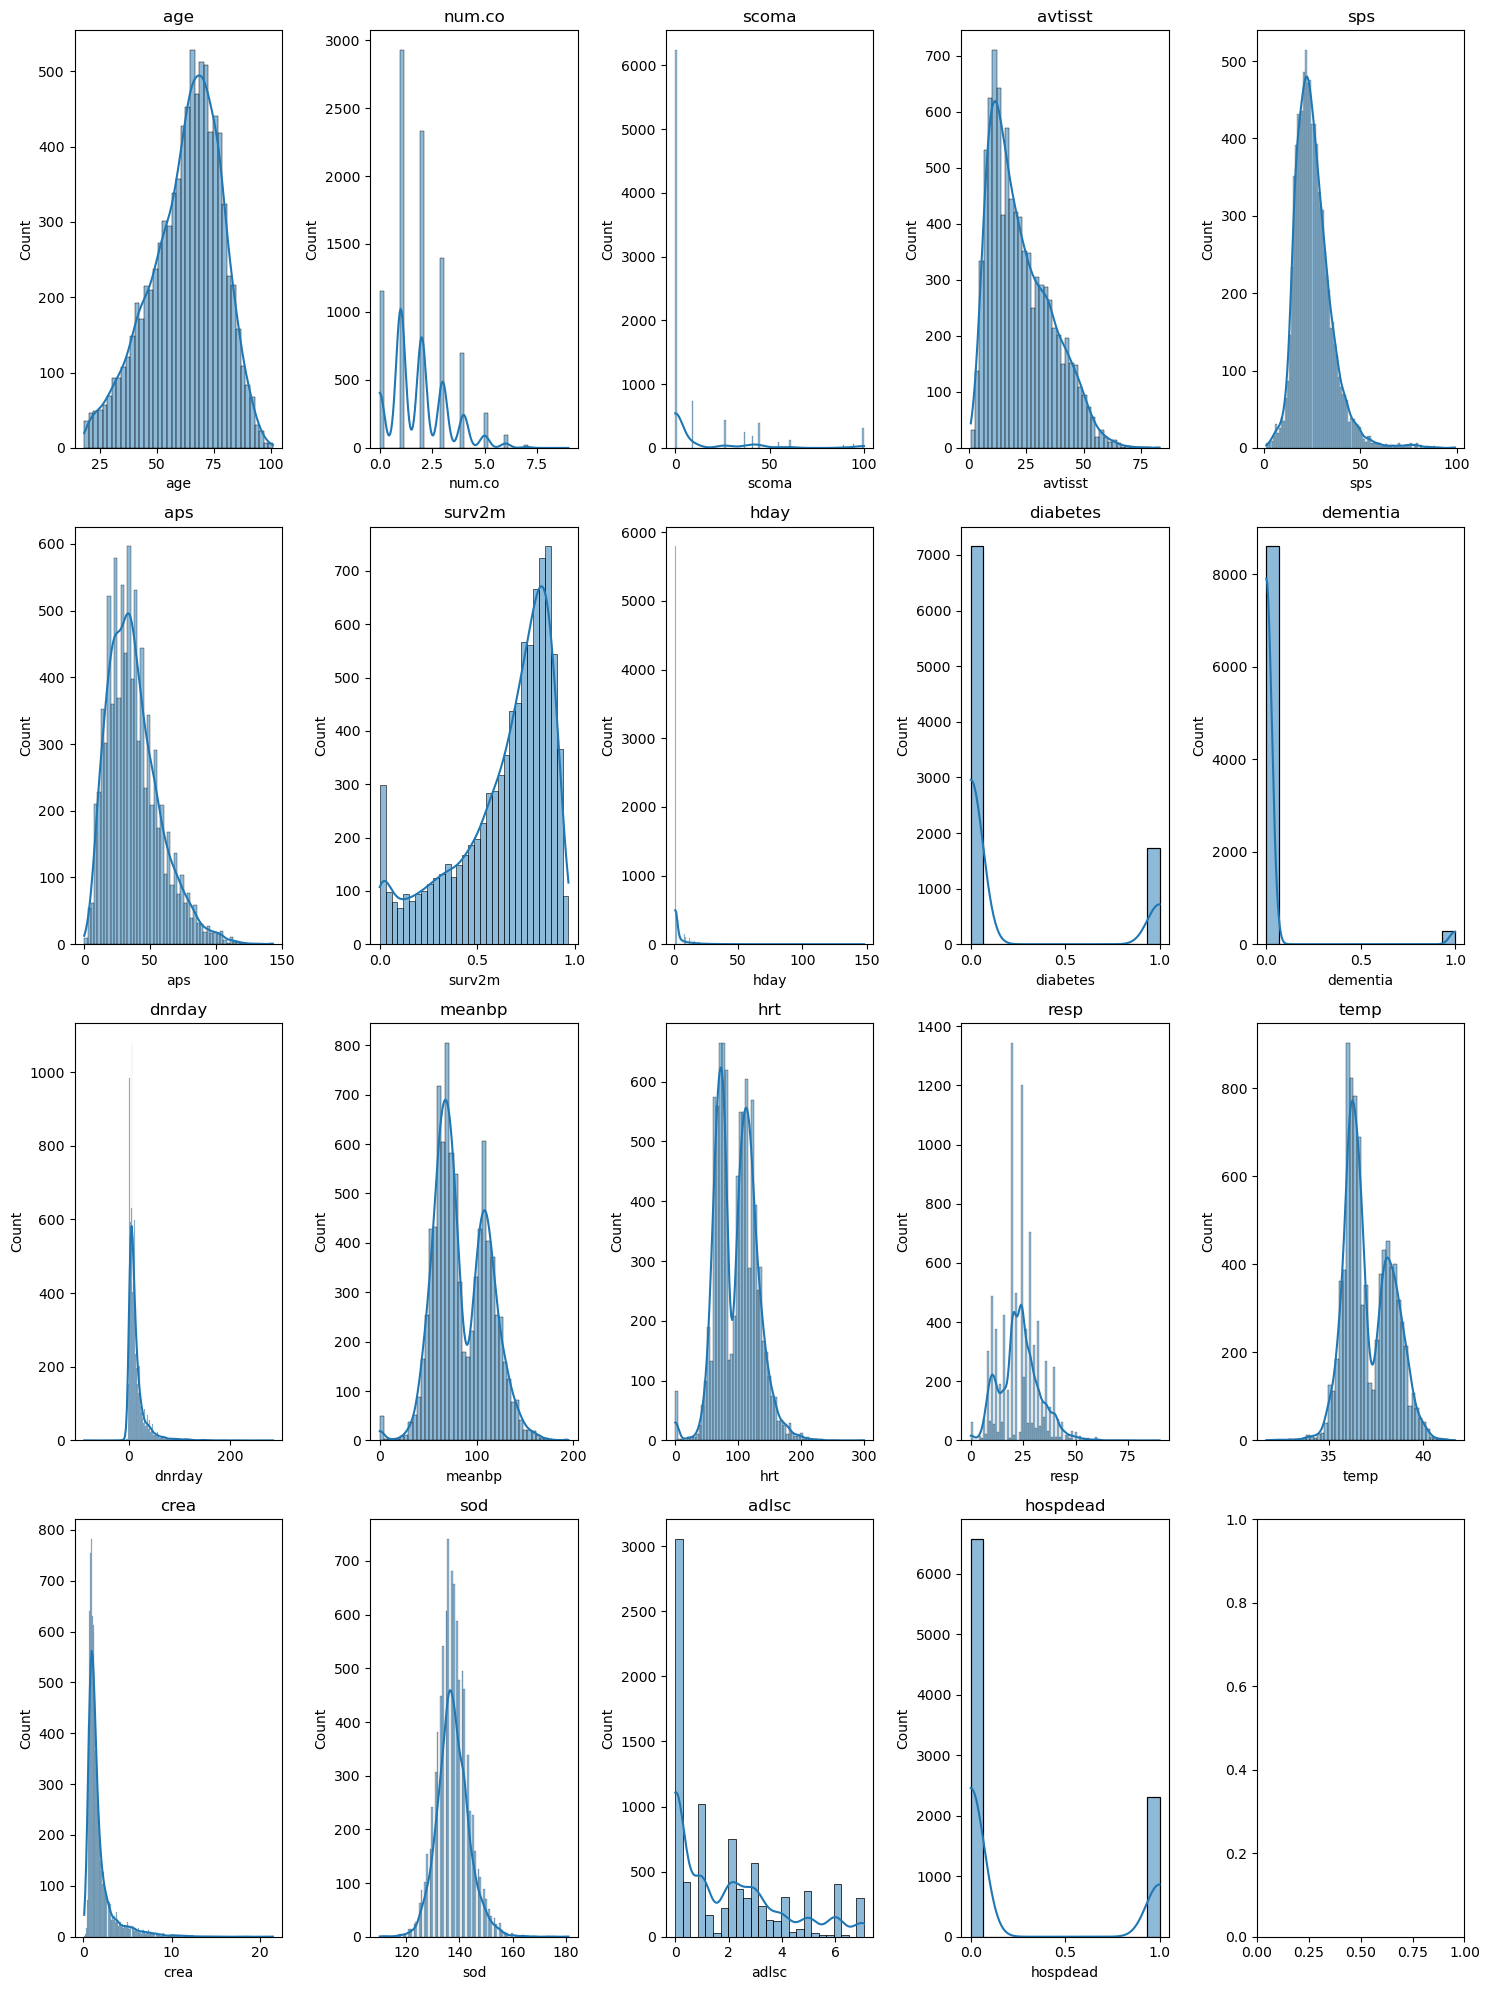

In [12]:
# Distribution charts of the features

n_cols = 5
n_rows = (len(datos.select_dtypes(include=[float, int]).columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(datos.select_dtypes(include = [float, int]).columns):
    sns.histplot(datos[col], kde = True, ax = axes[i]) 
    axes[i].set_title(f'{col}')
    
plt.tight_layout()
plt.show()

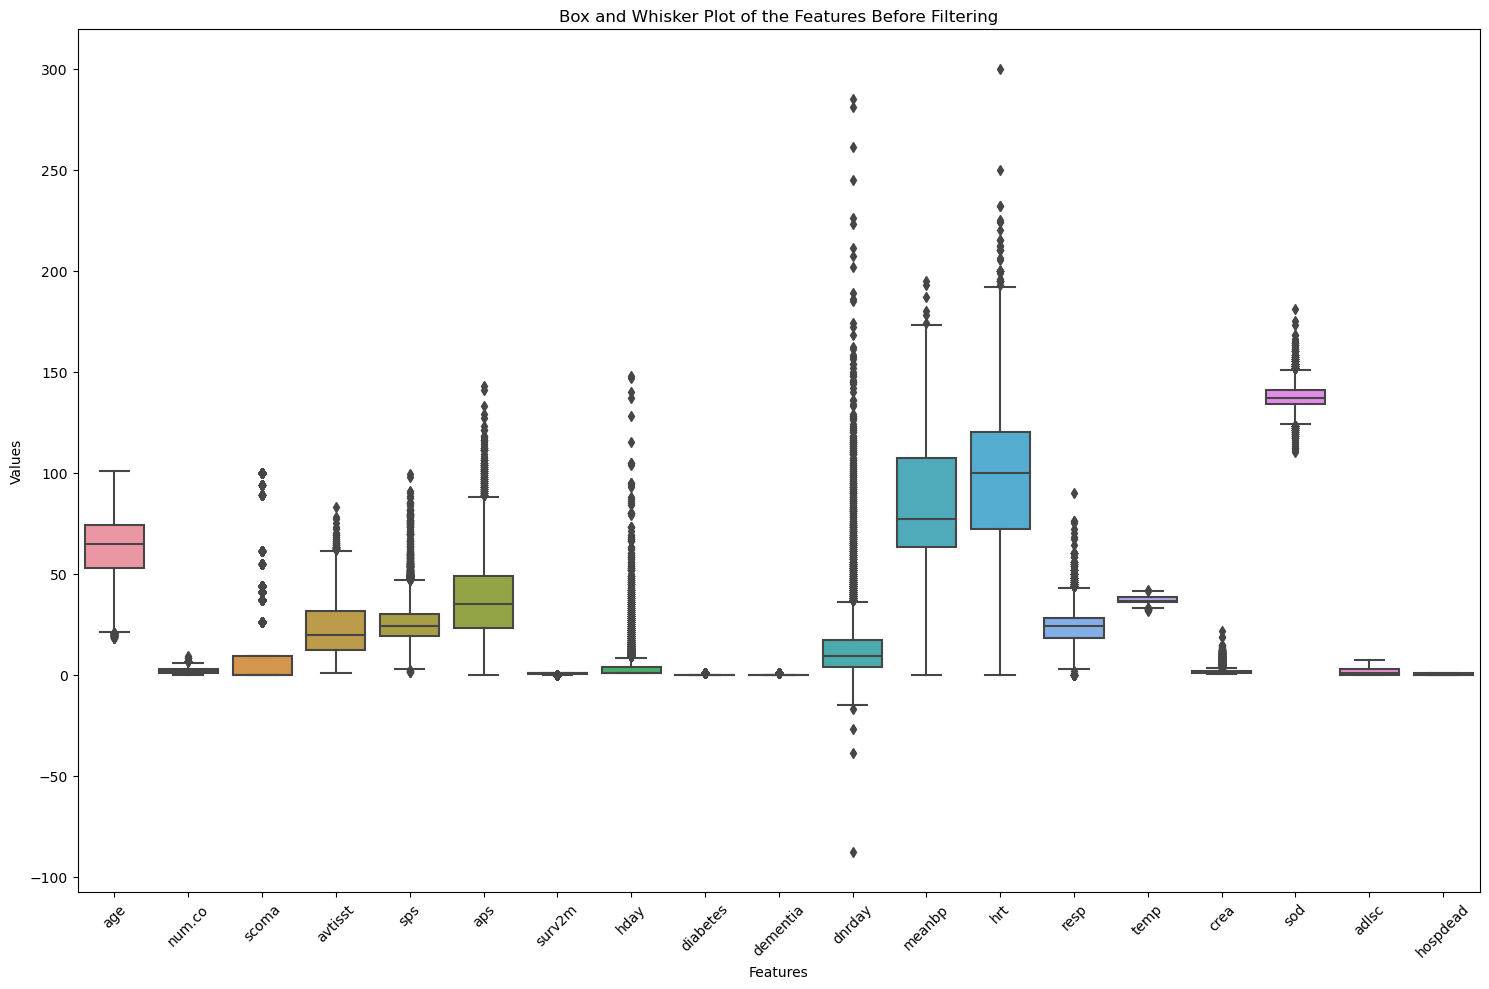

In [13]:
# Statistical Analysis with Box and Whisker Plots

plt.figure(figsize=(15, 10))
sns.boxplot(data=datos.select_dtypes(include=[float, int]))
plt.xticks(rotation=45)
plt.title('Box and Whisker Plot of the Features Before Filtering')
plt.xlabel('Features')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

From the distribution plots of the characteristics and the box-and-whisker plot it can be seen that many of the characteristics contain quite a lot of data that can be considered 'outliers', so a scaler that can deal with this is chosen: the RobustScaler. The objective stated in the problem is to identify the cases of death in a timely manner rather than to understand the factors that influence it the most. In other words, the performance of the model is prioritized over the explainability of the results. For this reason a dimensionality reduction step is included with PCA, which will help the classification algorithm but will make the data uninterpretable as before by taking it to another feature space. This is implemented a little later in the processing pipeline.

In [15]:
# Separate data in training and testing

X = datos.drop(columns = ['hospdead'])
y = datos['hospdead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
# Filtering

filter = False

if filter:
    # Winzorization
    variables_a_winsorizar = ['scoma', 'hday', 'dnrday', 'hospdead', 'diabetes', 'dementia', 'crea', 'resp']    
    for var in variables_a_winsorizar:
        X_train[var] = mstats.winsorize(X_train[var], limits=[0.01, 0.01])
        X_test[var] = mstats.winsorize(X_test[var], limits=[0.01, 0.01])
    # logaríthmic Transformación
    columns_to_log_transform = ['sps', 'aps', 'dnrday', 'hday', 'meanbp', 'hrt', 'crea']    
    for col in columns_to_log_transform:
        X_train[col] = np.where(X_train[col] <= 0, 1e-4, X_train[col])
        X_train[col] = np.log1p(X_train[col])
        
        X_test[col] = np.where(X_test[col] <= 0, 1e-4, X_test[col])
        X_test[col] = np.log1p(X_test[col])

Data filtering was tested using winzorization to remove outliers and a logarithmic transformation to eliminate biases and try to make the data distributions closer to the normal distribution and facilitate data learning. However, there was no improvement in any of the implemented algorithms, so this process was deactivated by default.

In [18]:
# Dividing data into numerical and categorical data

X_train_num = X_train.select_dtypes(include = ['int', 'float'])
X_train_cat = X_train.select_dtypes(include = ['object', 'category'])
X_test_num = X_test.select_dtypes(include = ['int', 'float'])
X_test_cat = X_test.select_dtypes(include = ['object', 'category'])

In [19]:
# Apply Scaling and Dimensionality Reduction to the Data

pipeline_data_processing = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95))  # Transformed to retain 95% of the variability of the original data
])

X_train_num_processed = pipeline_data_processing.fit_transform(X_train_num)
X_train_num_processed = pd.DataFrame(X_train_num_processed)
X_test_num_processed = pipeline_data_processing.transform(X_test_num)
X_test_num_processed = pd.DataFrame(X_test_num_processed)

# The numeric DataFrames lost their index (it was "reset") when passing through the pipeline. 
# To merge them back with the categorical data, we "reset" the indices for them.
X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)


In [20]:
#Re-assemble the data to obtain a final version that can be given to the sorting algorithm.

X_train_final = X_train_num_processed.join(pd.get_dummies(X_train_cat))
X_test_final = X_test_num_processed.join(pd.get_dummies(X_test_cat))

#### Random undersampling

In [22]:
undersampler = RandomUnderSampler()
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)
X_train_under, y_train_under = undersampler.fit_resample(X_train_final, y_train)
#plt.figure(figsize = (3, 3)) 
#y_train_under.value_counts().plot(kind='pie')
print(f'Total negatives: {y_train_under.value_counts()[0]}')
print(f'Total positives: {y_train_under.value_counts()[1]}')

Total negatives: 1848
Total positives: 1848


It was initially thought, since the imbalance is not extreme, to balance the classes by implementing oversampling techniques with SMOTE. However, having categorical data among the features, it would be necessary to resort to the use of one-hot-encoding or variants of SMOTE (such as SMOTENC) that can deal with this type of data. This tends to generate data with high dimensionality and sparsity, which is not desirable. In addition to the fact that there is an unresolved bug with the libraries needed to implement this (https://github.com/scikit-learn-contrib/imbalanced-learn/issues/995), it was decided to abandon this approach and explore the option of random sampling for models where costs are not implemented.

# **Exploration of Different Models and Approaches**

#### ***Model Selection***

In this stage different classification models are explored and for each of them a hyperparameter search is carried out (except for Naive bayes which has no parameters to fit) in order to get a notion of the performance. In each case the best model resulting from the grid search is taken and test data are used to verify the generalizability of the model. Metrics such as accuracy and sensitivity (for both classes) are taken into account and additionally the AUC (area under the curve) is evaluated since the data has an imbalance that favors the negative class. For this reason the grid search for the parameters is done with 'roc_auc' as the evaluation criterion. The K-fold cross validation functionality included in the GridSearchCV and RandomizedSearchCV function is used (5-fold by default).

In [27]:
# Gaussian Naive-Bayes

bayes = GaussianNB()
bayes.fit(X_train_final, y_train)
y_pred_bayes = bayes.predict(X_test_final)
print(classification_report(y_test, y_pred_bayes))

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_bayes)
lr_auc = auc(lr_recall, lr_precision)
print(f' The area under the AUC curve for Naive Bayes is: {round(lr_auc,3)}')

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1315
           1       0.59      0.76      0.67       463

    accuracy                           0.80      1778
   macro avg       0.75      0.79      0.76      1778
weighted avg       0.82      0.80      0.81      1778

 The area under the AUC curve for Naive Bayes is: 0.708


In [28]:
# Random Forest

params_random_forest = {
    'n_estimators': [100, 200, 350, 375, 500, 750, 1000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions = params_random_forest, scoring = 'accuracy', n_jobs = -1, verbose = 3, n_iter = 50)
random_search_rf.fit(X_train_final, y_train)
best_random_forest = random_search_rf.best_estimator_
y_pred_rf = best_random_forest.predict(X_test_final)
print(classification_report(y_test, y_pred_rf))
print("Best Random Forest:", random_search_rf.best_params_)

rf_precision, rf_recall, _ = precision_recall_curve(y_test, best_random_forest.predict_proba(X_test_final)[:, 1])
rf_auc = auc(rf_recall, rf_precision)
print(f'The area under the AUC curve for Random Forest is: {round(rf_auc, 3)}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1315
           1       0.79      0.76      0.77       463

    accuracy                           0.88      1778
   macro avg       0.85      0.84      0.85      1778
weighted avg       0.88      0.88      0.88      1778

Best Random Forest: {'n_estimators': 750, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
The area under the AUC curve for Random Forest is: 0.826


In [29]:
# XGBoost with costs

params_xgboost = {
    'n_estimators': [100, 200, 300, 350, 400, 450, 500],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10, 12]
}

grid_xgboost = GridSearchCV(XGBClassifier(scale_pos_weight = c0/c1), param_grid = params_xgboost, scoring = 'roc_auc', n_jobs = -1, verbose = 3)
grid_xgboost.fit(X_train_final, y_train)
best_xgboost = grid_xgboost.best_estimator_
y_pred_xgboost = best_xgboost.predict(X_test_final)
print(classification_report(y_test, y_pred_xgboost))
print("Best XGBoost:", grid_xgboost.best_params_)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_xgboost)
lr_auc = auc(lr_recall, lr_precision)
print(f' The area under the AUC curve for XGBoost is: {round(lr_auc,3)}')

Fitting 5 folds for each of 112 candidates, totalling 560 fits
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1315
           1       0.72      0.85      0.78       463

    accuracy                           0.88      1778
   macro avg       0.83      0.87      0.85      1778
weighted avg       0.89      0.88      0.88      1778

Best XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 450}
 The area under the AUC curve for XGBoost is: 0.805


In [30]:
# Logistic Regression

params_logReg = {
    'C': np.linspace(0.01, 2, 25),   
}
grid = GridSearchCV(LogisticRegression(), param_grid = params_logReg, scoring = 'roc_auc') 
grid.fit(X_train_under, y_train_under)
best_logReg = grid.best_estimator_
y_pred_logReg = best_logReg.predict(X_test_final)
print(classification_report(y_test, y_pred_logReg))
print("Best LogReg:", grid.best_params_)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_logReg)
lr_auc = auc(lr_recall, lr_precision)
print(f' The area under the AUC curve for Logistic Regression is: {round(lr_auc,3)}')

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1315
           1       0.69      0.85      0.76       463

    accuracy                           0.86      1778
   macro avg       0.81      0.86      0.83      1778
weighted avg       0.87      0.86      0.86      1778

Best LogReg: {'C': 0.09291666666666666}
 The area under the AUC curve for Logistic Regression is: 0.787


In [31]:
# Support Vector Machine

params_svm = {
    'C': np.linspace(0.01, 2, 10),  #regularization
    'kernel': ['linear', 'rbf', 'poly'],  # kernels
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid = params_svm, scoring = 'roc_auc')
grid.fit(X_train_under, y_train_under)
best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_final)
print(classification_report(y_test, y_pred_svm))
print("Best SVM:", grid.best_params_)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_svm)
lr_auc = auc(lr_recall, lr_precision)
print(f' The area under the AUC curve for Support Vector Machines is: {round(lr_auc,3)}')

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1315
           1       0.70      0.84      0.76       463

    accuracy                           0.86      1778
   macro avg       0.82      0.86      0.83      1778
weighted avg       0.88      0.86      0.87      1778

Best SVM: {'C': 1.557777777777778, 'gamma': 'scale', 'kernel': 'rbf'}
 The area under the AUC curve for Support Vector Machines is: 0.789


In [32]:
# Multilayer Perceptron (MLP)
# Used Scikit-learns implementation. For a more in-Depth analysis on MLPs Keras woould be more efficient and overall better

params_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 50, 50), (100, 100, 100)],
    'activation': ['relu', 'logistic'],
    'alpha': np.logspace(-1, 1, 5), #https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py
    'learning_rate': ['constant', 'adaptive'],
}

grid = RandomizedSearchCV(MLPClassifier(),param_distributions = params_mlp, n_iter = 50, scoring = 'roc_auc', n_jobs = -1, verbose = 3)
grid.fit(X_train_under, y_train_under)
best_mlp = grid.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_final)
print(classification_report(y_test, y_pred_mlp))
print("Best MLP:", grid.best_params_)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_mlp)
lr_auc = auc(lr_recall, lr_precision)
print(f' The area under the AUC curve for the Multi Layer Perceptron is: {round(lr_auc,3)}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1315
           1       0.72      0.84      0.77       463

    accuracy                           0.87      1778
   macro avg       0.83      0.86      0.84      1778
weighted avg       0.88      0.87      0.87      1778

Best MLP: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 3.1622776601683795, 'activation': 'relu'}
 The area under the AUC curve for the Multi Layer Perceptron is: 0.799


# **Analysis of Results**

In [34]:
# Certainty using Chernoff Bounds

n = len(y_test) # Amount of data used to evaluate the model
err = 1 - 0.88 # Accuracy of the best model
delta = 2*np.exp(-2*n*(err**2))
print(f'Level of certainty: {1-delta}')

Level of certainty: 1.0


Analyzing the results of all the implemented models, the first conclusion we reach is that the two models with the best performance for this case are XGBoost with costs and Random Forest using a data subsampling approach to balance the two classes. Both would perform well, so to speak, in different ways; however, for this particular problem, we lean towards XGBoost, as it has significantly higher sensitivity for the positive class, while Random Forest is more precise in this class (0.85 vs. 0.76 in terms of sensitivity). Since we want to identify cases of hospital mortality, we give more value to the model capable of identifying these cases even if its precision is slightly lower. Although Random Forest only achieves a sensitivity of 0.76, tying for last place, it is important to highlight that both alternatives demonstrate very good overall performance, reaching an AUC score of 0.82 for Random Forest and 0.805 for XGBoost, making both excellent options. They also achieve an accuracy of 0.88.

On the opposite end is the Naive Bayes classifier, which reaches a sensitivity of 0.76 (tying for last place with Random Forest), but it does not compensate with precision, which only reaches 0.59, the lowest of all. Its AUC score is also approximately 0.1 less than the other models. Its advantage, however, is that the time required for training and processing data is significantly shorter than that needed for the other models.

The remaining models show good performance, with sensitivity for the positive class ranging from 0.84 to 0.85 and precision fluctuating between 0.68 and 0.7, with an ROC of around 0.785. As can be noted, their performance is not far from that of XGBoost and Random Forest, which also makes them good models.

With the best model obtained from XGBoost, we will be able to predict 85% of the total cases of hospital mortality. There will be a 72% accuracy in the results for patients predicted to have a positive hospital mortality.

This means that we will know in advance about 85 out of every 100 patients who die in the hospital, and of every 100 patients we identify as having a fatal outcome from their hospitalization, we will be correct in 72% of the cases with absolute certainty, as demonstrated with the Chernoff bounds.

* exact numbers may vary slightly when re-running the code